# Gap Up Short

In [1]:
from datetime import datetime, date, time
from times import get_market_dates, get_market_calendar, last_trading_date_before
from data import get_data
from tickers import get_tickers
from portfolio import Portfolio
import json
import performance as performance
import pandas as pd
import numpy as np

DATA_PATH = "../data/polygon/"
START_DATE = date(2019, 6, 1)
END_DATE = date(2024, 3, 1)

Short at open if:
* 30% gap
* More than $1M pre-market volume
* Unadjusted price above $1

Cover:
* Always at market close
* No stoploss

Position sizing:
* 20% (max. 5)
* If more than 5, rank on largest gap

Other:
* 200 bps round-trip costs

In [2]:
# Initialize historical scanner, portfolio and calendar
with open("../output/screens/GAP_30PCT.json", "r") as f:
    G30 = json.load(f)

data = {}
portfolio = Portfolio(datetime.combine(START_DATE, time(0)), data, initial_capital=10000)
calendar = get_market_calendar("datetime")
stats = []

# LOOP THROUGH ALL DAYS
for day in get_market_dates(START_DATE, END_DATE):
    # Scan for gappers
    gappers_today = G30[day.isoformat()]
    if not gappers_today:
        continue

    # AT MARKET OPEN, calculate gaps and enter positions
    # Get data
    """
    The reason we don't use data = {}: We want the data and portfolio.data to refer to the same
    dictionary. When we use data = {}, this creates a NEW dictionary. Thus data will refer to
    this new dictionary and not the old. Then portfolio.data refers to the old. 
    When we do data.clear(), it empties the dictionary but does not create a new one.
    """
    data.clear() 
    
    previous_close_dt = calendar.at[last_trading_date_before(day), "regular_close"]
    market_open_dt = calendar.at[day, "regular_open"]
    market_close_dt = calendar.at[day, "regular_close"]
    for gapper in gappers_today:
        data[gapper] = get_data(
            gapper,
            previous_close_dt,
            market_close_dt,
            1,
            columns=["open", "high", "close", "tradeable", "close_original"],
        )

    # Calculate gaps
    gap = {}
    for gapper in gappers_today:
        previous_close = data[gapper].at[previous_close_dt, "close"]
        current_open = data[gapper].at[market_open_dt, "open"]
        gap[gapper] = current_open / previous_close

    # Get the top gappers
    sorted_gap = dict(sorted(gap.items(), key=lambda x: x[1], reverse=True))

    # Market order with 20% of cash
    size = portfolio.current_cash * 0.2
    for trade_no, gapper in enumerate(sorted_gap.keys()):
        current_open = data[gapper].at[market_open_dt, "open"]
        quantity = int(size / current_open)
        if quantity != 0:
            portfolio.update_from_fill(
                dt=market_open_dt,
                side="SELL",
                symbol=gapper,
                fill_quantity=quantity,
                fill_price=current_open,
                fees=current_open*0.01*abs(quantity),
            )
        if trade_no + 1 == 5:
            break

    # TODO: Implement 50% stoploss, taking into account gaps

    # AT MARKET CLOSE: close all positions, update portfolio
    portfolio.liquidate_everything(market_close_dt, fees_pct=1)
    
    # LOG STATISTICS: SPIKEET STYLE
    # for gapper in gappers_today:
    #     stats.append({'day': day,
    #                 'ticker': gapper,
    #                 'prev_close': data[gapper].loc[previous_close_dt, "close"],
    #                 'open': data[gapper].loc[market_open_dt, "open"],
    #                 'open_original': data[gapper].loc[market_open_dt, "close_original"], # not exactly correct
    #                 'high': data[gapper].loc[market_open_dt:market_close_dt, 'high'].max(),
    #                 'close': data[gapper].loc[market_close_dt, "close"],
    #                 })
               
    portfolio.append_portfolio_log(market_close_dt)

# END OF BACKTEST
# stats = pd.DataFrame(stats)
# stats.set_index("day", inplace=True)
# stats.to_excel("../output/gappers.xlsx")

In [3]:
portfolio_log = portfolio.get_df_from_holdings_log()
fills_log = portfolio.get_df_from_fills_log()
trade_log = performance.fills_to_trades_no_partials(fills_log) # Need to make this faster
trade_log = trade_log.drop(columns=['remaining_qty', 'net P/L $', 'fees'])

trade_log.to_csv('../output/trade_log_gappers.csv')

In [4]:
fills_log.head(3)

,symbol,side,quantity,fill_price,fees
datetime,,,,,
2019-06-04 09:30:00,CTRM-2019-06-03,SELL,2,898.00,17.9600
2019-06-04 15:59:00,CTRM-2019-06-03,BUY,2,585.00,11.7000
2019-06-05 09:30:00,LFWD-2024-01-30,SELL,38,55.51,21.0938


In [5]:
len(trade_log)

2903

In [6]:
trade_log[trade_log['net P/L %'] < -100].sort_values(by=['net P/L %']).head(3)

,datetime_in,symbol,side,quantity,entry,exit,datetime_out,net P/L %
2830,2024-02-07 09:30:00,HOLO-2022-09-19,SELL,1131207,3.76,18.64,2024-02-07 15:59:00,-401.70
2633,2023-10-11 09:30:00,TPST-2021-06-28,SELL,4030208,2.13,9.27,2023-10-11 15:59:00,-340.56
2102,2022-12-09 09:30:00,AMAM-2021-06-17,SELL,11202553,1.17,4.54,2022-12-09 15:59:00,-292.91


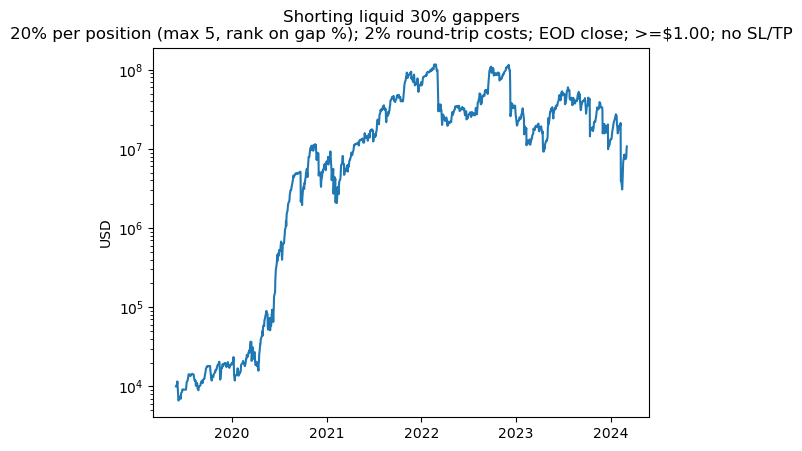

In [7]:
from matplotlib import pyplot as plt
plt.plot(portfolio_log.index, portfolio_log.equity)
plt.yscale("log")
plt.ylabel('USD')
plt.title('Shorting liquid 30% gappers\n20% per position (max 5, rank on gap %); 2% round-trip costs; EOD close; >=$1.00; no SL/TP')
plt.show()

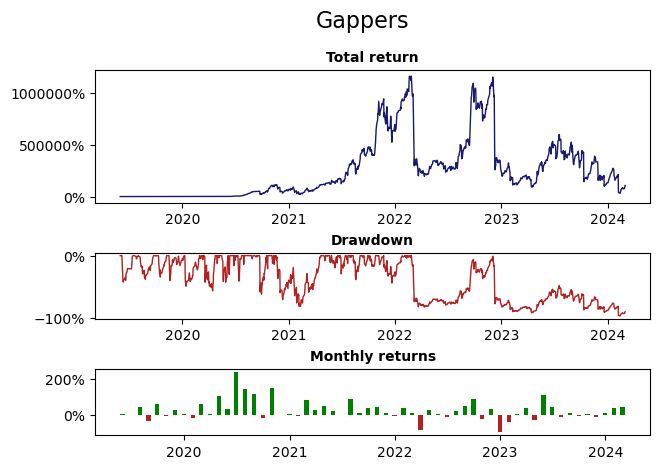

In [8]:
performance.plot_fig(portfolio_log, title='Gappers')

In [9]:
performance.display_stats(portfolio_log, fills_log, trade_log)

,
Annual return,334.2%
Sharpe,1.89
Sortina,1.73
Winning months,71.0%
Time in market,0.0%
Average profit,2.85%
Average duration per trade,6h28m
Profit factor,0.77
Trades/month,35.1
Annual fees,242.4%


### Parameter analysis
The purpose here is to see whether the inputs actually mattered and are robust. This is a mean-reversion system, so higher gaps should mean higher profits. In order to test this hypothesis, we will create 10 deciles of gap percentage and look at the average profit and standard deviation.

In [10]:
trade_log = pd.read_csv('../output/trade_log_gappers.csv', parse_dates=['datetime_in', 'datetime_out'], index_col=0)
calendar = get_market_calendar("datetime")

trade_log['gap'] = pd.Series(dtype='float')
trade_log.head(4)

,datetime_in,symbol,side,quantity,entry,exit,datetime_out,net P/L %,gap
0,2019-06-04 09:30:00,CTRM-2019-06-03,SELL,2,898.0000,585.0000,2019-06-04 15:59:00,33.20,NaN
1,2019-06-05 09:30:00,LFWD-2024-01-30,SELL,38,55.5100,51.5200,2019-06-05 15:59:00,5.26,NaN
2,2019-06-06 09:30:00,HEPA-2019-07-23,SELL,8,250.5752,140.7843,2019-06-06 15:59:00,42.25,NaN
3,2019-06-10 09:30:00,NBY-2019-06-03,SELL,59,38.6266,108.3302,2019-06-10 15:59:00,-184.26,NaN


In [11]:
for index, row in trade_log.iterrows():
    ticker = row['symbol']
    market_open_dt = row['datetime_in']
    previous_close_dt = calendar.loc[last_trading_date_before(market_open_dt.date()), "regular_close"]

    # Retrieve data and calculate gap percentage
    data = get_data(
        ticker,
        previous_close_dt,
        previous_close_dt,
        1,
        columns=["open", "high", "close", "tradeable", "close_original"],
    )
    market_open = row['entry']
    previous_market_close = data.loc[previous_close_dt, "close"]
    gap = (market_open/previous_market_close - 1)*100
    trade_log.at[index, 'gap'] = gap

trade_log['gap'] = round(trade_log['gap'], 0)


trade_log.to_csv('../output/trade_log_gappers.csv')

In [12]:
trade_log.sort_values('gap', ascending=False).head(5)

,datetime_in,symbol,side,quantity,entry,exit,datetime_out,net P/L %,gap
2671,2023-11-06 09:30:00,CREV-2023-11-03,SELL,24738,197.99,76.00,2023-11-06 15:59:00,60.23,2558.0
2539,2023-08-07 09:30:00,VTGN-2019-06-03,SELL,330141,21.60,12.80,2023-08-07 15:59:00,39.15,1186.0
726,2020-08-27 09:30:00,BETS-2023-09-08,SELL,25,35700.00,30750.00,2020-08-27 15:59:00,12.00,1089.0
2633,2023-10-11 09:30:00,TPST-2021-06-28,SELL,4030208,2.13,9.27,2023-10-11 15:59:00,-340.56,788.0
2705,2023-11-30 09:30:00,MINM-2021-07-07,SELL,400694,7.83,4.53,2023-11-30 15:59:00,40.57,760.0


Why is the data like this?

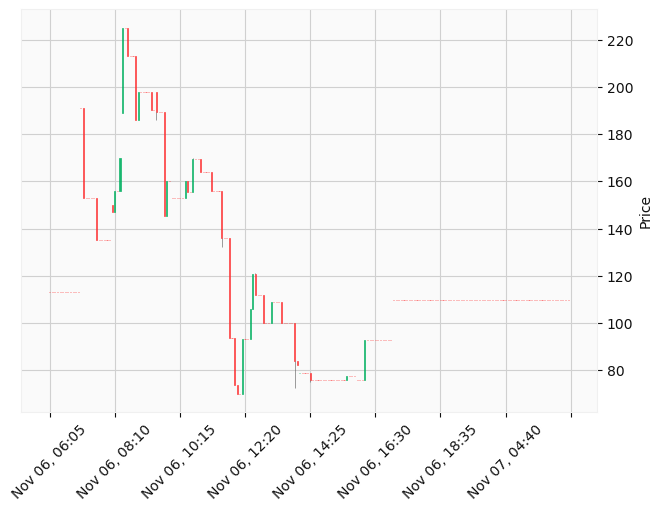

In [13]:
import mplfinance as mpf
bars = pd.read_parquet(DATA_PATH + f"processed/m5/CREV-2023-11-03.parquet")
bars = bars[bars.index > datetime(2023, 11, 6, hour=6)]
mpf.plot(bars.head(200), type='candle', style='yahoo')

It seems like only large gappers have a positive expectancy.

In [14]:
trade_log.groupby(pd.qcut(trade_log.gap, 10)).aggregate({'net P/L %': 'mean'})

,net P/L %
gap,
"(9.999, 33.0]",-0.778738
"(33.0, 37.0]",1.250930
"(37.0, 42.0]",-0.931163
"(42.0, 48.0]",0.282891
"(48.0, 56.0]",3.080369
"(56.0, 65.0]",2.313787
"(65.0, 79.0]",-0.975944
"(79.0, 100.0]",4.196952
"(100.0, 149.0]",9.502847


In [15]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import matplotlib.ticker as mtick
def plot_quintiles(trade_log, column, bins=5, title=None, aggregate_dict={'net P/L %': 'mean'}):
    quintiles = trade_log.groupby(pd.qcut(trade_log[column], bins)).aggregate(aggregate_dict)

    fig, ax = plt.subplots(figsize=(4, 4)) 
    ax.bar(range(1, bins+1), quintiles[next(iter(aggregate_dict))], color='green')
    ax.set_title(title, fontweight ='bold')
    ax.set_xlabel("Quantile (low to high)")
    ax.set(xticks=range(1, bins+1))
    ax.set_ylabel("Avg. net profit/trade")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    plt.show()

Let's consider gappers above 50%.

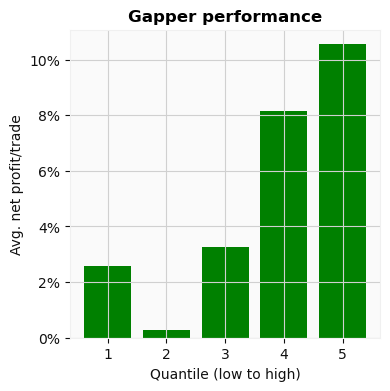

In [16]:
above_50 = trade_log[trade_log['gap'] > 50]
plot_quintiles(above_50, 'gap', title="Gapper performance")

Was this pattern generally consistent across all years? Because the profits are very volatile, we won't always expect the quantiles to have a monotonically increasing profit.

In [17]:
def plot_multiple_quintiles(trade_log, column, bins=5, title=None, aggregate_dict={'net P/L %': 'mean'}, figsize=(8, 5)):
    fig, axes = plt.subplots(2, 3, figsize=figsize)

    for ax, trade_log_split in zip(axes.reshape(-1), np.array_split(trade_log, axes.size)):
        quintiles = trade_log_split.groupby(pd.qcut(trade_log_split[column], bins)).aggregate(aggregate_dict)
        
        ax.bar(range(1, bins+1), quintiles[next(iter(aggregate_dict))], color='green')
        start_date = trade_log_split['datetime_in'].iloc[0].strftime('%b %Y')
        ax.set_title(f'>{start_date}')
        ax.set(xticks=range(1, bins+1))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    
    fig.suptitle(title, fontweight ='bold')
    fig.tight_layout()
    plt.show()

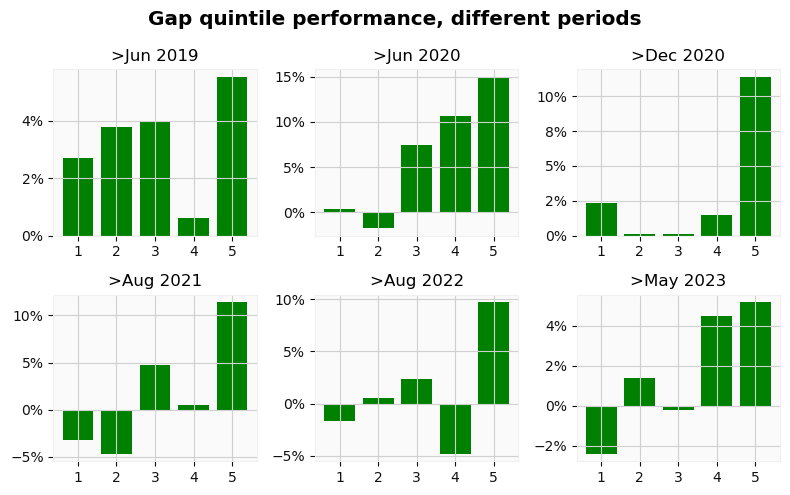

In [18]:
plot_multiple_quintiles(trade_log, 'gap', title='Gap quintile performance, different periods')

What is interesting to see is that in all years the 5th quintile was the best performing.